## Section 2: Natural Language Processing (NLP)

In section 1, we explore machine learning classification using traditional as well as deep learning methods utilizing transformer architecture. In this section, we will explore natural language processing (NLP) using the same transformer architecture. We will also explore the use of pre-trained models such as BERT in NLP.

In [6]:
import pandas as pd
import warnings

# suppress warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# load the processed data
df = pd.read_csv('data/processed/patients_with_ratings.csv')

# sample 1 percent of the data
df = df.sample(frac=0.015, random_state=1)

# preview the data
display(df.head())

,patient_id,age,gender,medical_history,deterioration_label,timestamp,hear_rate,blood_pressure_sys,blood_pressure_dia,oxygen_saturation,...,has_cancer,has_heart attack,has_heart failure,has_copd,has_asthma,has_alzheimer,has_dementia,fatigue_level,activity_level,mental_health_level
639,98227,72,Male,Recent pneumonia treated with antibiotics.,True,2023-10-26T10:35:00Z,100.5,115.7,75.4,93.0,...,0,0,0,0,0,0,0,4,2,2
616,be270,58,Male,History of controlled acid reflux. No other ch...,False,2023-10-27T13:30:00Z,70.0,128.0,84.0,97.5,...,0,0,0,0,0,0,0,1,3,4
1077,a7f10,71,Male,Diagnosed with influenza.,True,2023-10-27T22:30:00Z,90.0,130.0,85.0,93.0,...,0,0,0,0,0,0,0,4,2,2
1072,c55e9,32,Male,Broken arm (healing).,False,2023-10-27T20:00:00Z,70.0,120.0,78.0,99.0,...,0,0,0,0,0,0,0,3,2,2
816,d0bad,45,Other,Seasonal allergies. Otherwise healthy.,False,2023-10-27T10:20:00Z,72.0,110.0,70.0,100.0,...,0,0,0,0,0,0,0,1,5,3


## 1.1 Sentiment Analysis with BERT

In this section, we will explore the use of BERT for sentiment analysis on our dataset. To allow us to perform fine-tuning on BERT, we will make use of 

### 1.1.1 Data Preprocessing

We will create classes for the questionnaire data so that it can be used for training and testing. We will train 3 different BERT models on fatigue, lifestyle as well as mental health.

In [7]:
# Create sentiment labels for each column
def label_sentiment(df):
    # Copy the dataframe to avoid modifying the original
    df_sentiment = df.copy()
    
    # Fatigue level: 1-2 positive, 3 neutral, 4-5 negative
    df_sentiment['fatigue_sentiment'] = df_sentiment['fatigue_level'].apply(
        lambda x: 'positive' if x in [1, 2] else ('neutral' if x == 3 else 'negative')
    )
    
    # Activity level: 1-2 negative, 3 neutral, 4-5 positive (reversed scale)
    df_sentiment['activity_sentiment'] = df_sentiment['activity_level'].apply(
        lambda x: 'negative' if x in [1, 2] else ('neutral' if x == 3 else 'positive')
    )
    
    # Mental health level: 1-2 positive, 3 neutral, 4-5 negative
    df_sentiment['mental_health_sentiment'] = df_sentiment['mental_health_level'].apply(
        lambda x: 'positive' if x in [1, 2] else ('neutral' if x == 3 else 'negative')
    )
    
    return df_sentiment

# Apply the sentiment labeling
df_with_sentiment = label_sentiment(df)

# Display the original values and the new sentiment labels
display(df_with_sentiment[['fatigue_level', 'fatigue_sentiment', 
                          'activity_level', 'activity_sentiment',
                          'mental_health_level', 'mental_health_sentiment']].head(10))

# Count the sentiment distributions for each category
print("\nFatigue Sentiment Distribution:")
print(df_with_sentiment['fatigue_sentiment'].value_counts())

print("\nActivity Sentiment Distribution:")
print(df_with_sentiment['activity_sentiment'].value_counts())

print("\nMental Health Sentiment Distribution:")
print(df_with_sentiment['mental_health_sentiment'].value_counts())

,fatigue_level,fatigue_sentiment,activity_level,activity_sentiment,mental_health_level,mental_health_sentiment
639,4,negative,2,negative,2,positive
616,1,positive,3,neutral,4,negative
1077,4,negative,2,negative,2,positive
1072,3,neutral,2,negative,2,positive
816,1,positive,5,positive,3,neutral
1010,1,positive,4,positive,4,negative
674,2,positive,3,neutral,4,negative
647,5,negative,1,negative,1,positive
711,1,positive,4,positive,4,negative
671,5,negative,1,negative,1,positive



Fatigue Sentiment Distribution:
fatigue_sentiment
negative    9
positive    6
neutral     3
Name: count, dtype: int64

Activity Sentiment Distribution:
activity_sentiment
negative    11
positive     5
neutral      2
Name: count, dtype: int64

Mental Health Sentiment Distribution:
mental_health_sentiment
positive    10
negative     6
neutral      2
Name: count, dtype: int64


In [8]:
# construcut sentiment dataset
df_sentiment = df_with_sentiment[['fatigue_sentiment', 'activity_sentiment', 'mental_health_sentiment']].copy()

# add describe_fatigue, describe_activity, and describe_mental_health columns from the original dataset
df_sentiment['describe_fatigue_level'] = df['describe_fatigue_level']
df_sentiment['describe_lifestyle'] = df['describe_lifestyle']
df_sentiment['describe_mental_health'] = df['describe_mental_health']

# preview the sentiment dataset
display(df_sentiment.head())

,fatigue_sentiment,activity_sentiment,mental_health_sentiment,describe_fatigue_level,describe_lifestyle,describe_mental_health
639,negative,negative,positive,Significant fatigue and weakness remaining aft...,"Limited to home, recovering.",Worried about full recovery.
616,positive,neutral,negative,Normal.,"Works full-time, light exercise.",Good.
1077,negative,negative,positive,Severe body aches and fatigue.,Resting at home.,Feeling miserable.
1072,neutral,negative,positive,Some fatigue from injury.,Limited due to injury.,Impatient with recovery.
816,positive,positive,neutral,Rarely feels fatigued.,"Very active, participates in sports.",Positive mental health.


We can see that the data is being properly prepared to be used for training and testing.

### 1.1.2 Model Training

In this section we will train 3 separate BERT models on A100 GPU. 

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
from tqdm import tqdm

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [10]:
# Function to prepare dataset for BERT
def prepare_data_for_bert(text_column, label_column, test_size=0.2):
    # Handle NaN values
    valid_indices = text_column.notna()
    texts = text_column[valid_indices].tolist()
    labels = label_column[valid_indices].tolist()
    
    # Convert string labels to integers
    label_map = {'positive': 0, 'neutral': 1, 'negative': 2}
    labels = [label_map[label] for label in labels]
    
    # Split data into train and test sets
    train_texts, test_texts, train_labels, test_labels = train_test_split(
        texts, labels, test_size=test_size, random_state=42, stratify=labels
    )
    
    return train_texts, test_texts, train_labels, test_labels

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Function to tokenize and encode the texts
def encode_texts(texts, max_length=128):
    return tokenizer(
        texts,
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )

# Function to create torch dataset
def create_dataset(texts, labels):
    encodings = encode_texts(texts)
    input_ids = encodings['input_ids']
    attention_mask = encodings['attention_mask']
    labels = torch.tensor(labels)
    return TensorDataset(input_ids, attention_mask, labels)

In [ ]:
# Function to train the model - modified to return evaluation data
def train_bert_model(train_dataset, val_dataset, num_labels=3, epochs=3):
    # Initialize the model
    model = BertForSequenceClassification.from_pretrained(
        'bert-base-uncased',
        num_labels=num_labels
    ).to(device)
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16)
    
    # Set up optimizer
    optimizer = AdamW(model.parameters(), lr=2e-5)
    
    # Training loop
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        
        # Training phase
        model.train()
        train_loss = 0
        train_progress = tqdm(train_loader, desc="Training")
        
        for batch in train_progress:
            batch = tuple(b.to(device) for b in batch)
            input_ids, attention_mask, labels = batch
            
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            train_loss += loss.item()
            
            loss.backward()
            optimizer.step()
            
            train_progress.set_description(f"Training (loss={loss.item():.4f})")
        
        avg_train_loss = train_loss / len(train_loader)
        print(f"Training loss: {avg_train_loss:.4f}")
    
    # Final evaluation phase
    model.eval()
    val_loss = 0
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validation"):
            batch = tuple(b.to(device) for b in batch)
            input_ids, attention_mask, labels = batch
            
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            val_loss += loss.item()
            
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            predictions.extend(preds)
            true_labels.extend(labels.cpu().numpy())
    
    avg_val_loss = val_loss / len(val_loader)
    print(f"Validation loss: {avg_val_loss:.4f}")
    
    # Return the model and evaluation results
    return model, true_labels, predictions

# Function to run sentiment analysis for each aspect - modified to return evaluation results
def analyze_sentiment(df, text_column, label_column, model_name):
    print(f"\n--- {model_name} Sentiment Analysis Training ---\n")
    
    # Prepare data
    train_texts, test_texts, train_labels, test_labels = prepare_data_for_bert(
        df[text_column], df[label_column]
    )
    
    # Create datasets
    train_dataset = create_dataset(train_texts, train_labels)
    test_dataset = create_dataset(test_texts, test_labels)
    
    # Train model and get evaluation data
    model, true_labels, predictions = train_bert_model(train_dataset, test_dataset)
    
    # Save model
    model_path = f"models/bert_{model_name.lower().replace(' ', '_')}"
    model.save_pretrained(model_path)
    print(f"Model saved to {model_path}")
    
    return model, model_name, true_labels, predictions

# Dictionary to store evaluation results
eval_results = {}

# Run sentiment analysis for each aspect
print("\n=== Training All Sentiment Analysis Models ===\n")

fatigue_model, fatigue_name, fatigue_true, fatigue_pred = analyze_sentiment(
    df_sentiment, 
    'describe_fatigue_level', 
    'fatigue_sentiment',
    'Fatigue'
)
eval_results['Fatigue'] = (fatigue_true, fatigue_pred)

activity_model, activity_name, activity_true, activity_pred = analyze_sentiment(
    df_sentiment, 
    'describe_lifestyle', 
    'activity_sentiment',
    'Activity'
)
eval_results['Activity'] = (activity_true, activity_pred)

mental_health_model, mental_health_name, mental_health_true, mental_health_pred = analyze_sentiment(
    df_sentiment, 
    'describe_mental_health', 
    'mental_health_sentiment',
    'Mental Health'
)
eval_results['Mental Health'] = (mental_health_true, mental_health_pred)



=== Training All Sentiment Analysis Models ===


--- Fatigue Sentiment Analysis Training ---



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


Training (loss=1.2473): 100%|██████████| 1/1 [00:11<00:00, 11.01s/it]


Training loss: 1.2473
Epoch 2/3


Training (loss=1.1693): 100%|██████████| 1/1 [00:09<00:00,  9.55s/it]


Training loss: 1.1693
Epoch 3/3


Training (loss=1.0651): 100%|██████████| 1/1 [00:10<00:00, 10.29s/it]


Training loss: 1.0651


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Validation loss: 1.0616
Model saved to models/bert_fatigue

--- Activity Sentiment Analysis Training ---



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


Training (loss=1.0474): 100%|██████████| 1/1 [00:12<00:00, 12.46s/it]


Training loss: 1.0474
Epoch 2/3


Training (loss=0.9915): 100%|██████████| 1/1 [00:17<00:00, 17.02s/it]


Training loss: 0.9915
Epoch 3/3


Training (loss=0.9187): 100%|██████████| 1/1 [00:14<00:00, 14.13s/it]


Training loss: 0.9187


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Validation loss: 1.0158
Model saved to models/bert_activity

--- Mental Health Sentiment Analysis Training ---



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


Training (loss=1.3049): 100%|██████████| 1/1 [00:16<00:00, 16.09s/it]


Training loss: 1.3049
Epoch 2/3


Training (loss=1.1810): 100%|██████████| 1/1 [00:15<00:00, 15.44s/it]


Training loss: 1.1810
Epoch 3/3


Training (loss=1.1255): 100%|██████████| 1/1 [00:17<00:00, 17.31s/it]


Training loss: 1.1255


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


Validation loss: 1.1410
Model saved to models/bert_mental_health


EVALUATION REPORTS FOR ALL SENTIMENT ANALYSIS MODELS

Fatigue Model Evaluation:
----------------------------------------
              precision    recall  f1-score   support

    positive       0.00      0.00      0.00         1
     neutral       0.00      0.00      0.00         1
    negative       0.67      1.00      0.80         2

    accuracy                           0.50         4
   macro avg       0.22      0.33      0.27         4
weighted avg       0.33      0.50      0.40         4




Activity Model Evaluation:
----------------------------------------
              precision    recall  f1-score   support

    positive       0.00      0.00      0.00         1
     neutral       0.00      0.00      0.00         1
    negative       0.50      1.00      0.67         2

    accuracy                           0.50         4
   macro avg       0.17      0.33      0.22         4
weighted avg       0.25      0.50 

In [30]:
# Display all evaluation reports after all models are trained
print("\n\n" + "="*70)
print("EVALUATION REPORTS FOR ALL SENTIMENT ANALYSIS MODELS")
print("="*70)

label_names = ['positive', 'neutral', 'negative']
for model_name, (true_labels, predictions) in eval_results.items():
    print(f"\n{model_name} Model Evaluation:")
    print("-" * 40)
    print(classification_report(true_labels, predictions, target_names=label_names))
    print("\n")

import pickle
# Save the evaluation results to a pickle file
with open('models/nlp_eval_results.pkl', 'wb') as f:
    pickle.dump(eval_results, f)



EVALUATION REPORTS FOR ALL SENTIMENT ANALYSIS MODELS

Fatigue Model Evaluation:
----------------------------------------
              precision    recall  f1-score   support

    positive       0.00      0.00      0.00         1
     neutral       0.00      0.00      0.00         1
    negative       0.67      1.00      0.80         2

    accuracy                           0.50         4
   macro avg       0.22      0.33      0.27         4
weighted avg       0.33      0.50      0.40         4




Activity Model Evaluation:
----------------------------------------
              precision    recall  f1-score   support

    positive       0.00      0.00      0.00         1
     neutral       0.00      0.00      0.00         1
    negative       0.50      1.00      0.67         2

    accuracy                           0.50         4
   macro avg       0.17      0.33      0.22         4
weighted avg       0.25      0.50      0.33         4




Mental Health Model Evaluation:
---------

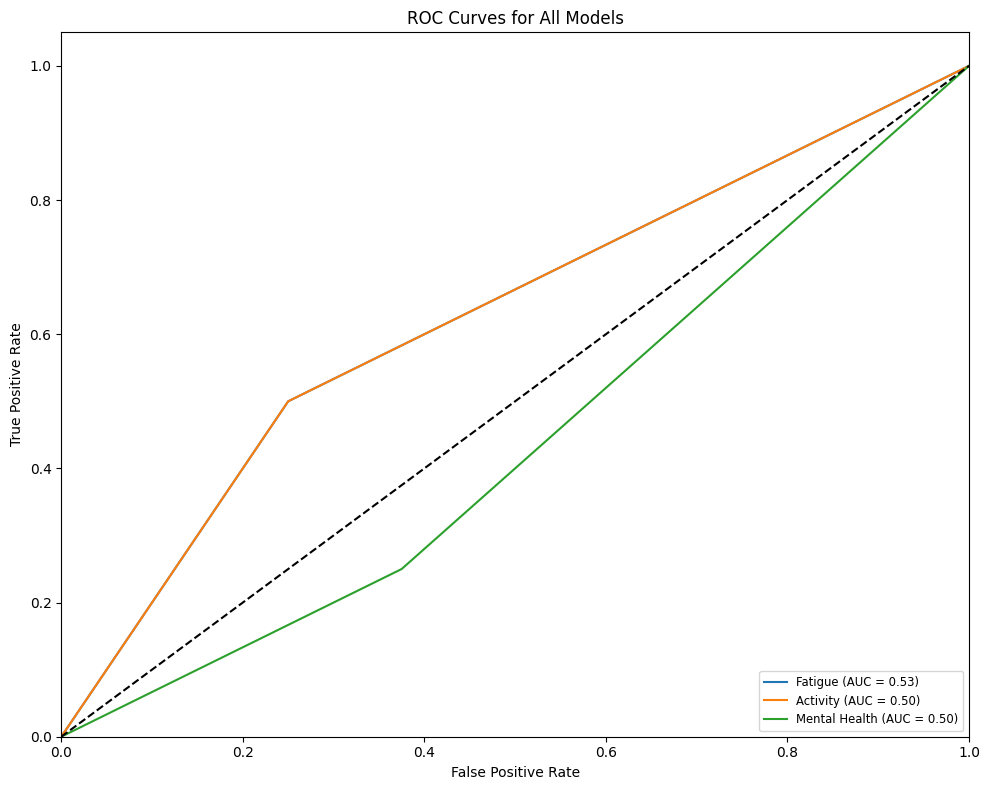

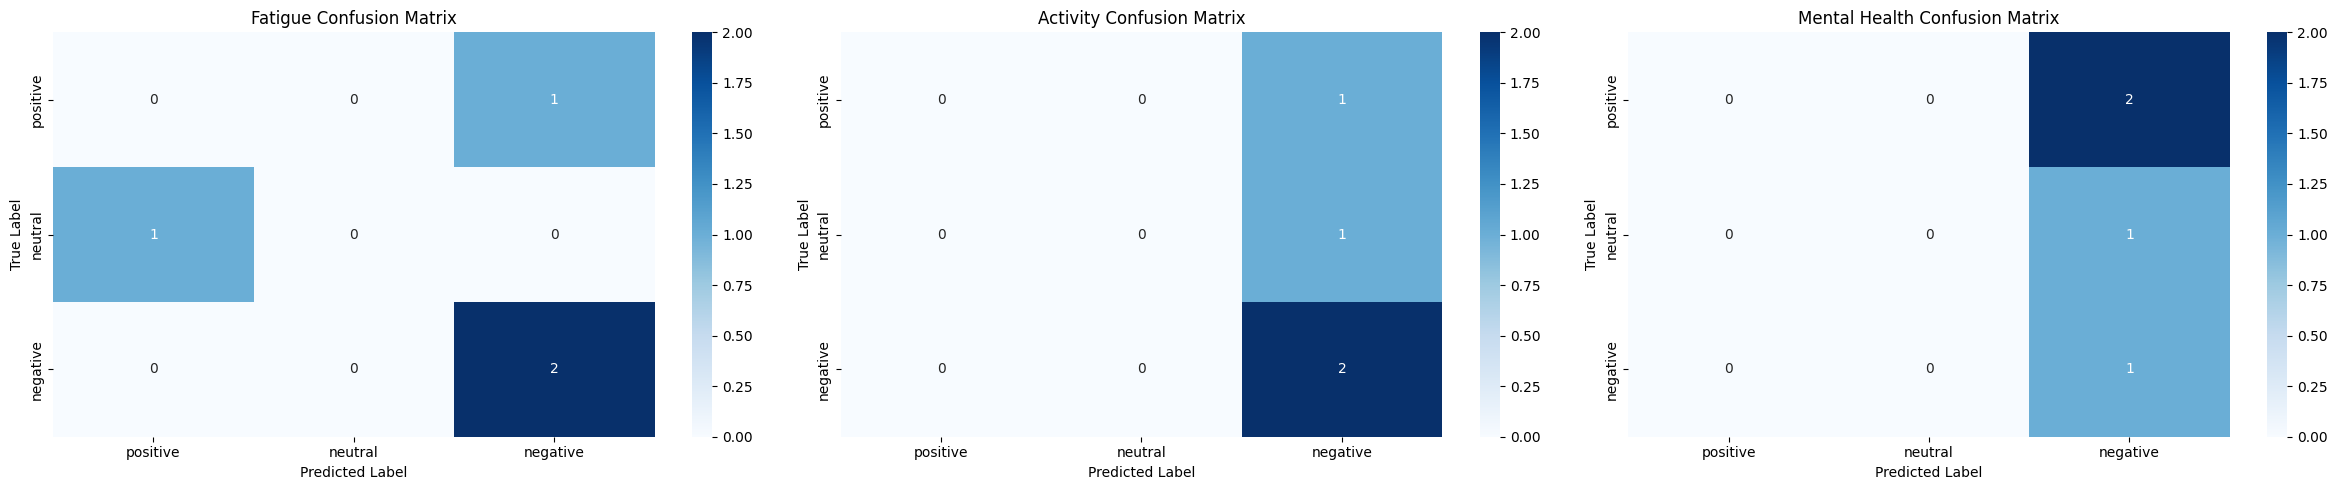

<Figure size 640x480 with 0 Axes>

,Model,Accuracy,Precision,Recall,F1-Score,AUC
0,Fatigue,0.500000,0.333333,0.500000,0.400000,0.527778
1,Activity,0.500000,0.250000,0.500000,0.333333,0.500000
2,Mental Health,0.250000,0.062500,0.250000,0.100000,0.500000


In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

def evaluate_and_visualize_models(eval_results):
    """Evaluate models and create visualizations."""
    # Create an empty list to store evaluation results as dictionaries
    eval_records = []
    
    # Classes for label mapping
    classes = ['positive', 'neutral', 'negative']
    
    # Set up the figure for confusion matrices
    fig_cm, axes_cm = plt.subplots(1, 3, figsize=(24, 5))
    
    # Create a separate figure for the ROC curve
    fig_roc, ax_roc = plt.subplots(figsize=(10, 8))
    
    # Process each model's results
    for i, (model_name, (true_labels, predictions)) in enumerate(eval_results.items()):
        # Get the classification report as a dict
        report = classification_report(true_labels, predictions, 
                                       target_names=classes, 
                                       output_dict=True)
        
        # Calculate average AUC across all classes for this model
        model_auc = 0
        for class_idx, class_name in enumerate(classes):
            y_true_class = (np.array(true_labels) == class_idx).astype(int)
            y_pred_class = (np.array(predictions) == class_idx).astype(int)
            fpr, tpr, _ = roc_curve(y_true_class, y_pred_class)
            model_auc += auc(fpr, tpr)
        model_auc /= len(classes)  # Average AUC across all classes
        
        # Add a single record for this model (moved outside the class loop)
        eval_records.append({
            'Model': model_name,
            'Accuracy': report['accuracy'],
            'Precision': report['weighted avg']['precision'],
            'Recall': report['weighted avg']['recall'],
            'F1-Score': report['weighted avg']['f1-score'],
            'AUC': model_auc
        })
        
        # Plot confusion matrix
        cm = confusion_matrix(true_labels, predictions)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=classes, yticklabels=classes, ax=axes_cm[i])
        axes_cm[i].set_title(f'{model_name} Confusion Matrix')
        axes_cm[i].set_ylabel('True Label')
        axes_cm[i].set_xlabel('Predicted Label')
        
        # One-hot encode true labels for micro-averaging
        n_classes = 3
        y_true_bin = label_binarize(true_labels, classes=[0, 1, 2])
        
        # For each model, generate prediction scores for each class
        # We'll use the predicted classes directly for simplicity
        y_score = label_binarize(predictions, classes=[0, 1, 2])
        
        # Compute micro-average ROC curve and ROC area
        fpr, tpr, _ = roc_curve(y_true_bin.ravel(), y_score.ravel())
        roc_auc = auc(fpr, tpr)
        
        # Plot the ROC curve for this model (one line per model)
        ax_roc.plot(fpr, tpr, 
                    label=f'{model_name} (AUC = {model_auc:.2f})')
    
    
    # Add diagonal line to ROC plot
    ax_roc.plot([0, 1], [0, 1], 'k--')
    ax_roc.set_xlim([0.0, 1.0])
    ax_roc.set_ylim([0.0, 1.05])
    ax_roc.set_xlabel('False Positive Rate')
    ax_roc.set_ylabel('True Positive Rate')
    ax_roc.set_title('ROC Curves for All Models')
    ax_roc.legend(loc="lower right", fontsize='small')
    
    # Adjust layout and save figures
    fig_cm.tight_layout()
    fig_cm.savefig('images/sa_confusion_matrices.png', dpi=300, bbox_inches='tight')
    
    fig_roc.tight_layout()
    fig_roc.savefig('images/sa_roc_curves.png', dpi=300, bbox_inches='tight')
    
    # Show both figures
    plt.figure(fig_cm.number)
    plt.show()
    plt.figure(fig_roc.number)
    plt.show()
    
    # Create DataFrame from the list of records
    eval_df = pd.DataFrame(eval_records)
    
    # Save evaluation results to CSV
    eval_df.to_csv('data/output/sentiment_model_evaluation.csv', index=False)
    
    # Display the evaluation table
    display(eval_df.style.highlight_max(axis=0))
    
    return eval_df

eval_df = evaluate_and_visualize_models(eval_results)